# **Momentum Scanner**

> This code analyzes a list of stocks from the Indian stock market (NSE) and ranks them based on their momentum over various periods (6 months, 3 months, and 1 month). It uses technical indicators such as Exponential Moving Averages (EMAs) and Relative Strength Index (RSI) to identify stocks with strong upward trends and potential for future growth. The code generates a table and a plot visualizing the top-ranked stocks based on their momentum scores.

---

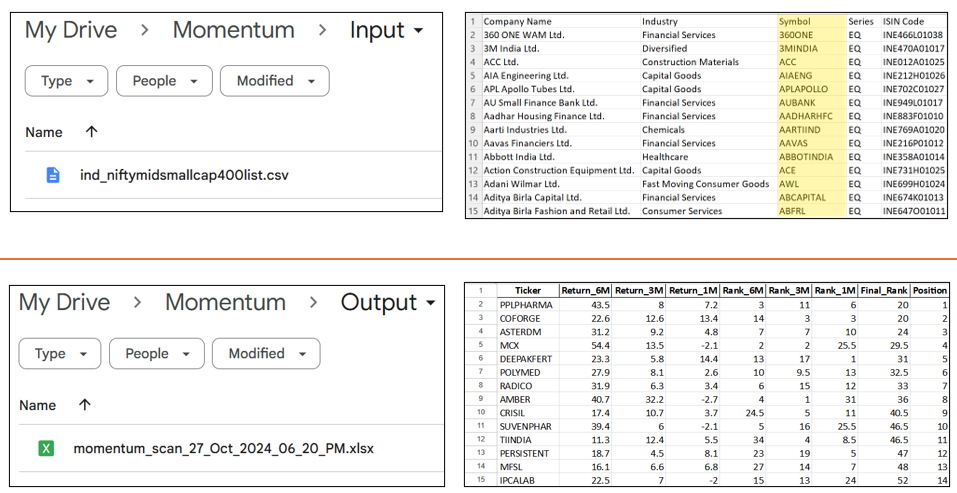

**Import Necessary Libraries**

Imports libraries for financial analysis, data handling, and visualization.

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
from matplotlib.table import Table
from google.colab import drive, files

**Configuration**

Sets parameters for data sources, momentum calculation, technical indicators, and stock selection criteria.

In [36]:
# Google Drive Input and Output Locations
input_symbols_drive_path = '/content/drive/MyDrive/Momentum/Input/ind_niftymidsmallcap400list.csv'
output_folder = '/content/drive/MyDrive/Momentum/Output'

# No of years of stock data
no_of_years_of_stock_data = 2

# Candles (Period) - For duration of return calculation
# Example: 6 months = 126 Candles | 3 Months = 63 Candles | 1 Month = 21 Candles
short_term_period = 21
medium_term_period = 63
long_term_period = 126

# Technical Indicators
rsi_period = 14

# Stock Selection Criteria:

# Minimum last one year return. Should be greater than FD return (7%)
minimum_one_year_return = 7

# Percentage range for the stock price from its 52 Weeks High
within_52_weeks_high_pct = 20

# Up days (green candles) percentage over long term period
minumun_up_days_pct = 45

**Load Stock Symbols**

Mount Google Drive to access a list of Indian stock symbols from a CSV file. Creates the corresponding tickers by appending '.NS' to each symbol.

The commented out code represents an alternative way to define the stock symbols manually, instead of reading them from a CSV file.

In [37]:
drive.mount('/content/drive')
symbols = pd.read_csv(input_symbols_drive_path)

symbols['Tickers'] = symbols['Symbol']+'.NS'
tickers = symbols['Tickers'].tolist()


# symbols = ["PERSISTENT","NATIONALUM"]
# tickers = [symbol + '.NS' for symbol in symbols]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Downloads daily historical data for stocks**


In [38]:
# Data dictionary to hold stock data
data = {}

# Set dates
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * no_of_years_of_stock_data)

daily_data_interval = "1d"

daily_data = yf.download(
    tickers=tickers,
    threads=True,
    group_by='ticker',
    start=start_date,
    interval=daily_data_interval)


[*********************100%***********************]  400 of 400 completed


**RSI Calculation**

Calculate the Relative Strength Index (RSI) for a stock's price data.

In [39]:
def rsi(df, period):

    delta = df["Close"].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()
    RS = _gain / _loss
    RSI = 100 - (100 / (1 + RS))
    df['RSI'] = RSI
    return df

**Stock Filtering and Analysis**

Filter the stocks using conditions:


*   Stock should not be new, should be listed at least 6 months ago
*   EMA (Stock Price Should be above key Moving Averages 50, 100, 200)
*   RSI should be greater than 40
*   Last one year return should be greater than 7-8% (FD Return)
*   Within 20% or 25% from 52-Week High
*   Up Days (Green Candles) Percentage should be greater than 45%


In [40]:
# Create a DataFrame for summary
summary = []

pct_multiplier = round((100 - within_52_weeks_high_pct) / 100, 2)

counter = 0
for ticker in tickers:
    df = daily_data[ticker].copy()
    symbol = ticker.replace(".NS", "")
    df.dropna(inplace=True)

    # No. of candles in stock data
    no_of_rows = df.shape[0]

    # If stock data is less than six months (126 candles)
    if df.empty or no_of_rows < six_months_candles:
        continue

    counter += 1

    ema_condition = False
    last_one_year_return_condition = False
    within_pct_52_week_high_condition = False
    up_days_pct_condition = False


    try:

        # Latest close price
        latest_close_price = round(df['Close'].iloc[-1], 2)

        # Calculate EMA-100
        df['EMA_50'] = df['Close'].ewm(span=50).mean()
        df['EMA_100'] = df['Close'].ewm(span=100).mean()

        latest_ema_50 = round(df['EMA_50'].iloc[-1], 2)
        latest_ema_100 = round(df['EMA_100'].iloc[-1], 2)

        # Calculate RSI
        df = rsi(df, rsi_period)
        daily_rsi = round(df['RSI'].iloc[-1], 2)


        pct_multiplier = round((100 - within_52_weeks_high_pct) / 100, 2)

        # Check if there is sufficient data (more than one year)
        # Calculate EMA-200, 52 Weeks High and one year return
        if no_of_rows >= 252:

            # 52-week high
            high_52_week = round((df['High'][-252:]).max(), 2)
            within_pct_52_week_high_condition = latest_close_price >= high_52_week * pct_multiplier

            # Last one year return
            last_one_year_price = round(df['Close'].iloc[-252], 2)
            one_year_return = round((latest_close_price / last_one_year_price - 1) * 100, 2)

            # Last one year return condition
            last_one_year_return_condition = one_year_return >= minimum_one_year_return

            df['EMA_200'] = df['Close'].ewm(span=200).mean()
            latest_ema_200 = round(df['EMA_200'].iloc[-1], 2)

            # EMA condition
            ema_condition = latest_close_price >= latest_ema_50 and\
                            latest_ema_50 > latest_ema_100 and\
                            latest_ema_100 > latest_ema_200

        else:
            # 52-week high
            high_52_week = round((df['High'][-no_of_rows:]).max(), 2)
            within_pct_52_week_high_condition = latest_close_price >= high_52_week * pct_multiplier

            # Last one year return condition
            # If stock data is less than a year, return since stock is listed
            one_year_return = round((latest_close_price/ df['Close'].iloc[-no_of_rows] - 1) * 100, 2)
            last_one_year_return_condition = one_year_return >= minimum_one_year_return

            # EMA condition
            ema_condition = latest_close_price >= latest_ema_50 and\
                            latest_ema_50 > latest_ema_100

        # More than 45% up days in the last 6 months (126 trading days)
        long_term_data = df['Close'].iloc[-long_term_period:]

        up_days = (long_term_data.pct_change() > 0).sum()
        up_days_pct = up_days / len(long_term_data) * 100

        up_days_pct_condition = up_days_pct > minumun_up_days_pct


        rsi_condition = daily_rsi > 40

        # Filtering criteria
        if (ema_condition and
            last_one_year_return_condition and
            within_pct_52_week_high_condition and
            up_days_pct_condition and
            rsi_condition):

            # Calculate returns
            return_6m = (df['Close'].iloc[-1] / df['Close'].iloc[-63] - 1) * 100
            return_3m = (df['Close'].iloc[-1] / df['Close'].iloc[-21] - 1) * 100
            return_1m = (df['Close'].iloc[-1] / df['Close'].iloc[-5] - 1) * 100

            summary.append({
                'Ticker': symbol,
                'Return_6M': return_6m,
                'Return_3M': return_3m,
                'Return_1M': return_1m,
            })
    except Exception as e:
        print(f"Error analyzing {symbol}: {e}")


**Ranks stocks by momentum, select top performers**

In [44]:
# Convert summary to DataFrame
df_summary = pd.DataFrame(summary)

# Round off returns to 1 decimal place
df_summary['Return_6M'] = df_summary['Return_6M'].round(1)
df_summary['Return_3M'] = df_summary['Return_3M'].round(1)
df_summary['Return_1M'] = df_summary['Return_1M'].round(1)

# Ranking based on returns
df_summary['Rank_6M'] = df_summary['Return_6M'].rank(ascending=False)
df_summary['Rank_3M'] = df_summary['Return_3M'].rank(ascending=False)
df_summary['Rank_1M'] = df_summary['Return_1M'].rank(ascending=False)

# df_summary['Cumulative_Return'] = df_summary['Return_6M'] + df_summary['Return_3M'] + df_summary['Return_1M']
# df_summary['Final_Rank'] = df_summary['Cumulative_Return'].rank(ascending=False)

# Calculate final rank
df_summary['Final_Rank'] = df_summary['Rank_6M'] + df_summary['Rank_3M'] + df_summary['Rank_1M']

# Sort by final rank and get top 30
df_summary_sorted = df_summary.sort_values('Final_Rank').head(40)

# Assign position based on final rank
df_summary_sorted['Position'] = np.arange(1, len(df_summary_sorted) + 1)

# Separate top 15 and next 15
top_15 = df_summary_sorted.head(15)
next_15 = df_summary_sorted.iloc[15:30]

# Prepare table data
tbl_data = []
for i, row in df_summary_sorted.iterrows():
    tbl_data.append([row['Ticker'],
                     row['Return_6M'], row['Rank_6M'],
                     row['Return_3M'], row['Rank_3M'],
                     row['Return_1M'], row['Rank_1M'],
                     row['Final_Rank'], row['Position']])

**Save the stock rankings to an Excel file on Google Drive.**

In [42]:
# save table in Excel file in Google drive

ist_timezone = pytz.timezone('Asia/Kolkata')
current_datetime_ist = datetime.now(ist_timezone)
date_string = current_datetime_ist.strftime("%d_%b_%Y_%I_%M_%p")

output_file_path = f'{output_folder}/momentum_scan_{date_string}.xlsx'

# Assuming 'df_summary_sorted' is your DataFrame
df_summary_sorted.to_excel(output_file_path, index=False)

print("Excel file saved to Google Drive.")

# If you want to download the file locally as well, you can uncomment the following line:
# files.download(output_file_path)

Excel file saved to Google Drive.


**Visualizes the top stock rankings using a table and highlights the top 15 stocks**

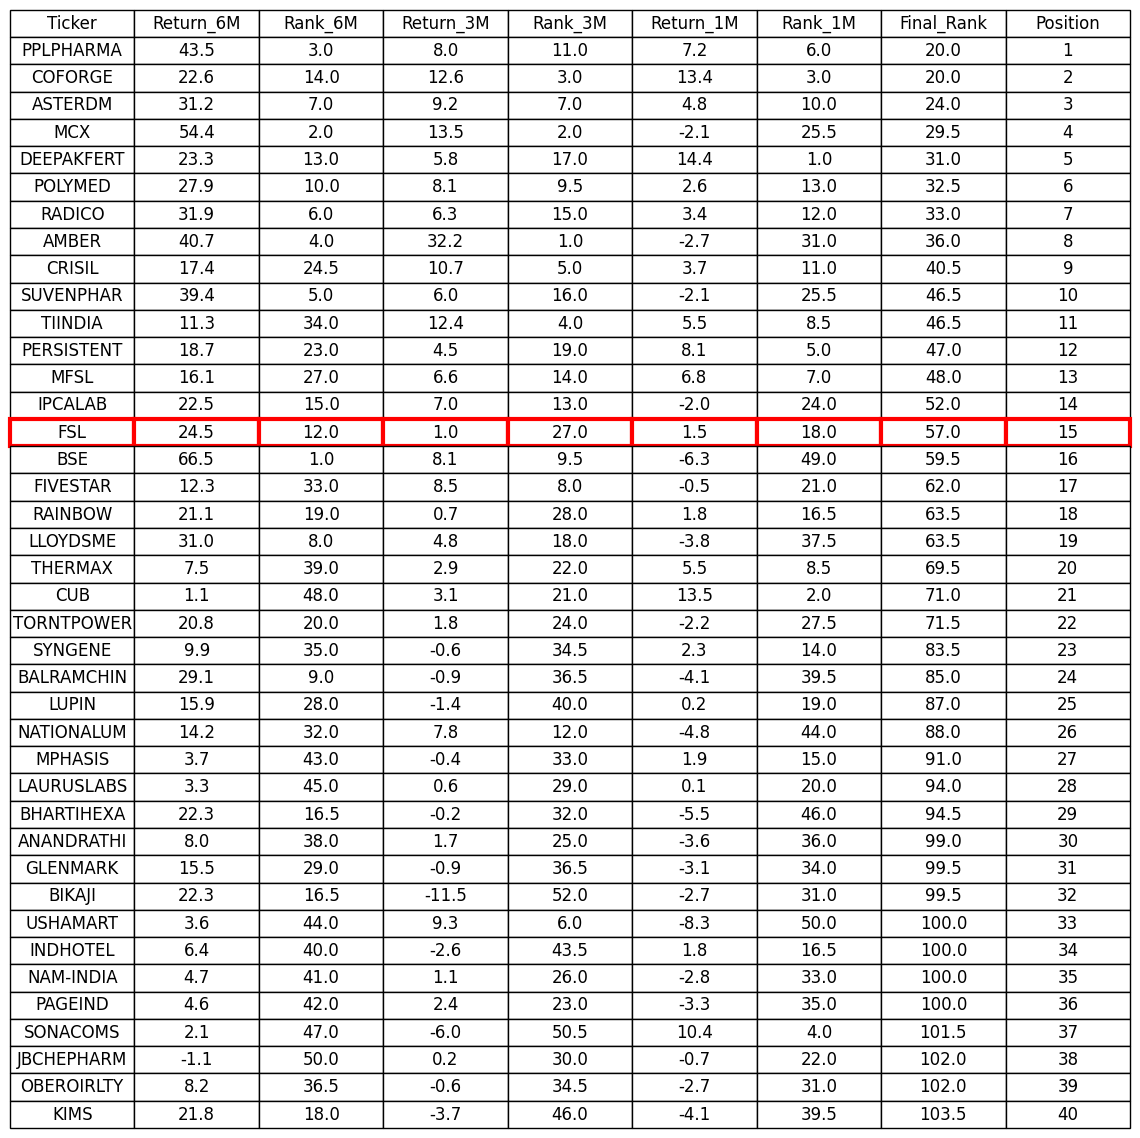

In [43]:
# Plot the results using matplotlib
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('tight')
ax.axis('off')

# Create a table
col_labels = ['Ticker', 'Return_6M', 'Rank_6M', 'Return_3M', 'Rank_3M', 'Return_1M', 'Rank_1M', 'Final_Rank','Position']
table = ax.table(cellText=tbl_data, colLabels=col_labels, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Draw a red line to separate the top 15
for i in range(len(col_labels)):
    cell = table[(15, i)]
    cell.set_edgecolor('red')
    cell.set_linewidth(3)

# Adjust layout
plt.subplots_adjust(left=0.1, top=0.95)  # Adjust top parameter for title position
#plt.title('Top 40 Stocks Momentum Ranking', fontsize=18, y=1.05)  # y parameter for title position
plt.show()